In [21]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors
import numpy as np
import random
import networkx as nx
import os
import matplotlib as mpl
from matplotlib import font_manager
from pyvis.network import Network
from matplotlib.colors import PowerNorm
try:
    if "Fira Sans" in [f.name for f in font_manager.fontManager.ttflist]:
        mpl.rcParams["font.family"] = "Fira Sans"
    else:
        raise KeyError("No Fira Sans? :3")
except:
    try:
        for font in os.listdir(os.path.join(os.path.dirname(os.getcwd()), "fonts")):
            font_manager.fontManager.addfont(os.path.join(os.path.join(os.path.dirname(os.getcwd()), "fonts"), font))
        font_manager.fontManager = font_manager.FontManager()
        if "Fira Sans" in [f.name for f in font_manager.fontManager.ttflist]:
            mpl.rcParams["font.family"] = "Fira Sans"
        else:
            raise ValueError("No Fira Sans in fonts folder...")
    except:
        mpl.rcParams["font.family"] = "DejaVu Sans"
tgss = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'featurized_TgSS.csv'))

In [22]:
tgss.replace([np.inf, -np.inf], np.nan, inplace=True)
tgss.dropna(axis=1, inplace=True)
features = list(set([d[0] for d in Descriptors._descList]) - set(['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 
                                                                  'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 
                                                                  'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'Ipc']))
X = tgss[features].copy()
y_tg = tgss["Tg"].copy()
y_pc = tgss[[col for col in tgss.columns if col.startswith("poly")]].copy()
print(f"Initial feature count: {len(Descriptors._descList)}, after removing sparse features: {len(features)}.")

Initial feature count: 217, after removing sparse features: 204.


In [23]:
selector = VarianceThreshold(threshold=0.1)
X_selected = selector.fit_transform(X)

In [24]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_selected)
features = selector.get_feature_names_out()
print(f"After removing features with variance < 0.1: {len(features)}.")

After removing features with variance < 0.1: 133.


In [25]:
important_features = ["MolWt", "Phi", "SPS"]

In [26]:
def remove_features_from_pairs(high_corr_pairs, import_feat, seed=None, draw=False):
    if seed is not None:
        random.seed(seed)
    G = nx.Graph()
    G.add_edges_from(high_corr_pairs)
    remove_set = set()
    for component in nx.connected_components(G):
        subG = G.subgraph(component).copy()
        edges = list(subG.edges())
        nodes = set(subG.nodes())
        while edges:
            u, v = random.choice(edges)
            if u in import_feat and v in import_feat:
                raise ValueError(f"High correlation pair {u}, {v} both are important features")
            elif u not in import_feat and v not in import_feat:
                c = random.choice([u, v])
            else:
                c = u if v in import_feat else v
            if len(nodes) > 1:
                remove_set.add(c)
                nodes.remove(c)
            edges = [(x, y) for (x, y) in edges if c not in (x, y)]
    if draw:
        net = Network(notebook=True, height="800px", width="100%", bgcolor="#3B3B3B", font_color="white")
        for n in G.nodes():
            if n in import_feat:
                net.add_node(n, label=n, color="green")
            elif n in remove_set:
                net.add_node(n, label=n, color="red")
            else:
                net.add_node(n, label=n, color="gray")
        for u, v in G.edges():
            net.add_edge(u, v)
        net.barnes_hut(gravity=-100, central_gravity=0.07, spring_length=250, spring_strength=0.01, damping=0.0475)
        net.show(os.path.join(os.path.dirname(os.getcwd()), 'plots', 'high_correlation_feature_network.html'))
        with open(os.path.join(os.path.dirname(os.getcwd()), 'plots', 'high_correlation_feature_network.html'), "r") as f:
            html = f.read()
        legend = """
            <div style="
                position: absolute;
                top: 12px;
                right: 12px;
                background: rgba(20, 20, 20, 0.92);
                padding: 10px 14px;
                border-radius: 8px;
                font-size: 14px;
                color: #eee;
                z-index: 99999;
                border: 1px solid rgba(255,255,255,0.15);
                box-shadow: 0 0 8px rgba(0,0,0,0.4);
                backdrop-filter: blur(4px);
            ">
                <div style="font-weight:bold; margin-bottom:6px; text-align:center;">
                    Legend
                </div>
                <div style="margin-bottom:4px;">
                    <span style="color: #2ecc71; font-size:16px;">●</span> Important
                </div>
                <div style="margin-bottom:4px;">
                    <span style="color: #e74c3c; font-size:16px;">●</span> Removed
                </div>
                <div>
                    <span style="color: #bfbfbf; font-size:16px;">●</span> Other
                </div>
            </div>
        """
        html = html.replace("</body>", legend + "\t\n</body>").replace("width: 100%", "width: 100%; height: 100%;")
        with open(os.path.join(os.path.dirname(os.getcwd()), 'plots', 'high_correlation_feature_network.html'), "w") as f:
            f.write(html)
    return remove_set

In [27]:
X_scaled_thresholded = pd.DataFrame(scaled_data, columns=features)
corr_old = X_scaled_thresholded.corr(method='pearson')
threshold = 0.85
high_corr_pairs = [(i, j) for i in corr_old.columns for j in corr_old.columns if i < j and abs(corr_old.loc[i,j]) > threshold]

In [28]:
removed_features = remove_features_from_pairs(high_corr_pairs, important_features, 0, True)
print(removed_features)

c:\Users\Andy\Documents\GitHub\cs4641-polymer-property-detection\plots\high_correlation_feature_network.html
{'fr_C_O', 'NHOHCount', 'VSA_EState1', 'Kappa1', 'Chi1v', 'NumHAcceptors', 'HallKierAlpha', 'Chi0v', 'SMR_VSA7', 'NOCount', 'NumHeteroatoms', 'HeavyAtomMolWt', 'HeavyAtomCount', 'Kappa3', 'Chi0', 'fr_alkyl_halide', 'FpDensityMorgan3', 'PEOE_VSA14', 'SlogP_VSA6', 'fr_amide', 'fr_benzene', 'Chi2v', 'NumUnspecifiedAtomStereoCenters', 'MaxAbsEStateIndex', 'Chi4n', 'VSA_EState6', 'FpDensityMorgan2', 'ExactMolWt', 'LabuteASA', 'SMR_VSA2', 'fr_C_O_noCOO', 'NumHDonors', 'MolLogP', 'NumAliphaticHeterocycles', 'NumAromaticRings', 'NumAmideBonds', 'NumAliphaticCarbocycles', 'Chi0n', 'NumRotatableBonds', 'Kappa2', 'Chi1', 'Chi2n', 'NumValenceElectrons', 'BertzCT', 'RingCount', 'Chi3n', 'Chi4v', 'MolMR', 'Chi1n'}


In [29]:
new_features = list(set(features)-set(removed_features))
X_reduced = X[new_features].copy()
print(f"After removing pairs with correlation > 0.85: {len(new_features)}.")

After removing pairs with correlation > 0.85: 84.


In [10]:
corr = X_reduced.corr(method='pearson')

In [11]:
fig = plt.figure(figsize=(len(features) * 0.5 * 2 + 0.05, len(features) * 0.5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    corr_old,
    cmap='coolwarm',
    center=0,
    annot=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=ax1
)
ax1.set_title("Before", fontsize=160)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=ax2
)
ax2.set_title("After (All Absolute Correlation < 0.85)", fontsize=160)
ax_cb = fig.add_subplot(gs[0, 2])
norm = plt.cm.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=ax_cb, fraction=1, pad=0.05)
cbar.ax.tick_params(labelsize=120)
cbar.set_label("Correlation", fontsize=140)
plt.show()

In [12]:
pca = PCA(n_components=len(new_features))
principal_components = pca.fit_transform(X_reduced)
explained_variance = pca.explained_variance_ratio_

Text(41, 0.9906013468550988, 'explains 99.96% of variance')

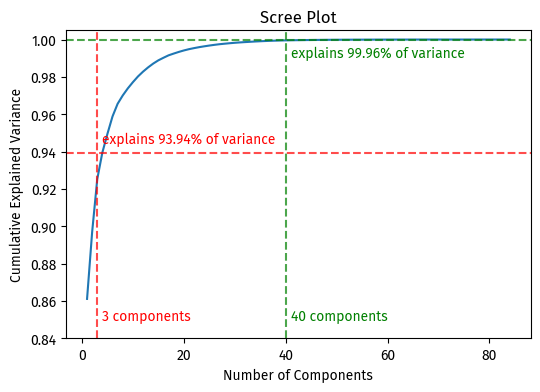

In [30]:
fig, ax = plt.subplots(figsize = (6,4))

ax.plot(np.array(list(range(len(explained_variance))))+1, np.cumsum(explained_variance))
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Scree Plot')
ax.set_ylim((0.84,1.005))

threshold = 0.9
components_90 = np.argmax(np.cumsum(explained_variance) >= threshold) + 1
ax.axhline(y=np.cumsum(explained_variance)[components_90], color='red', linestyle='--', alpha=0.7)
ax.axvline(x=components_90, color='red', linestyle='--', alpha=0.7)
ax.text(components_90+1, 0.85, f'{components_90} components', color='red')
ax.text(components_90+1, np.cumsum(explained_variance)[components_90] + 0.005, f'explains {np.cumsum(explained_variance)[components_90]*100:.2f}% of variance', color='red')
components = 40
ax.axhline(y=np.cumsum(explained_variance)[components], color='green', linestyle='--', alpha=0.7)
ax.axvline(x=components, color='green', linestyle='--', alpha=0.7)
ax.text(components+1, 0.85, f'{components} components', color='green')
ax.text(components+1, np.cumsum(explained_variance)[components] - 0.009, f'explains {np.cumsum(explained_variance)[components]*100:.2f}% of variance', color='green')

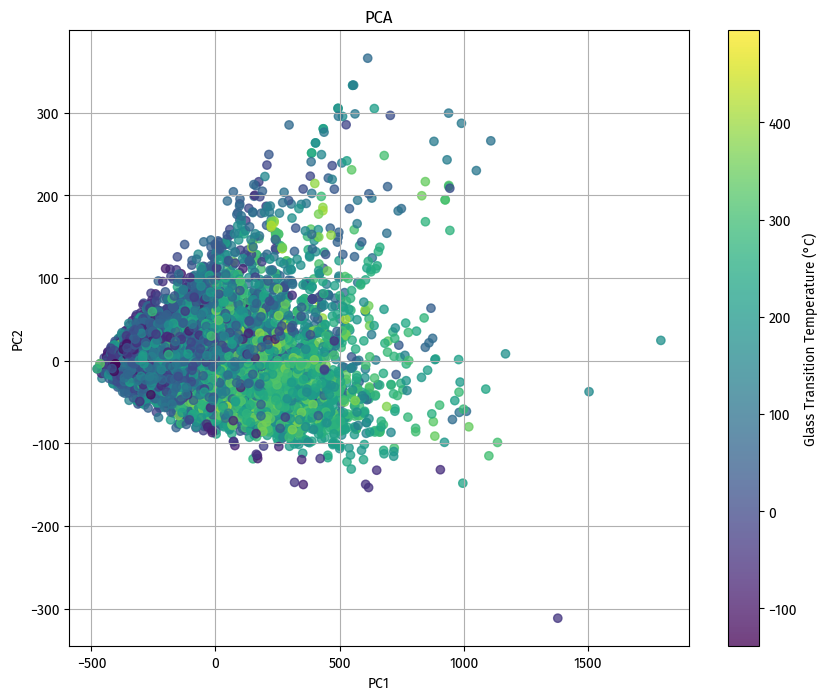

In [14]:
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(new_features))])
pca_df['Glass Transition Temperature'] = y_tg
plt.figure(figsize=(10, 8))
i, j = 1, 2
plt.scatter(
    pca_df[f'PC{i}'],
    pca_df[f'PC{j}'],
    c=pca_df['Glass Transition Temperature'],
    cmap='viridis',
    alpha=0.75
)
plt.title('PCA')
plt.xlabel(f'PC{i}')
plt.ylabel(f'PC{j}')
plt.colorbar(label='Glass Transition Temperature (°C)')
plt.grid()
plt.show()

In [15]:
loadings_df = pd.DataFrame(pca.components_.T,
                           columns=[f'PC{i+1}' for i in range(len(new_features))],
                           index=new_features)
explained_variance = pca.explained_variance_ratio_
weighted_contributions = loadings_df.abs().dot(explained_variance)
feature_rank = weighted_contributions.sort_values(ascending=False)
print("\nFeatures ranked by weighted variance contribution:")
print(feature_rank)
most_important_features = feature_rank.head(40).index.tolist()
print(f"\nThe forty most important features are: {most_important_features}")
tgss_most_important_features = tgss[["SMILES", "Tg", "Polymer Class"] + [col for col in tgss.columns if col.startswith("poly")] + sorted(most_important_features)].copy()


Features ranked by weighted variance contribution:
MolWt                       0.841110
TPSA                        0.152753
SlogP_VSA5                  0.095319
VSA_EState2                 0.076695
EState_VSA7                 0.076140
                              ...   
fr_nitrile                  0.000304
NumBridgeheadAtoms          0.000244
fr_methoxy                  0.000228
fr_para_hydroxylation       0.000208
NumSaturatedHeterocycles    0.000202
Length: 84, dtype: float64

The forty most important features are: ['MolWt', 'TPSA', 'SlogP_VSA5', 'VSA_EState2', 'EState_VSA7', 'EState_VSA6', 'EState_VSA8', 'SMR_VSA10', 'EState_VSA3', 'EState_VSA5', 'EState_VSA4', 'SlogP_VSA2', 'PEOE_VSA7', 'SMR_VSA1', 'SMR_VSA9', 'SMR_VSA5', 'EState_VSA1', 'PEOE_VSA6', 'EState_VSA2', 'EState_VSA10', 'SlogP_VSA8', 'SlogP_VSA10', 'SlogP_VSA1', 'SMR_VSA6', 'SlogP_VSA11', 'EState_VSA9', 'PEOE_VSA9', 'SlogP_VSA3', 'Chi3v', 'Phi', 'SlogP_VSA7', 'PEOE_VSA10', 'PEOE_VSA8', 'VSA_EState3', 'SlogP_VSA4', 'VSA

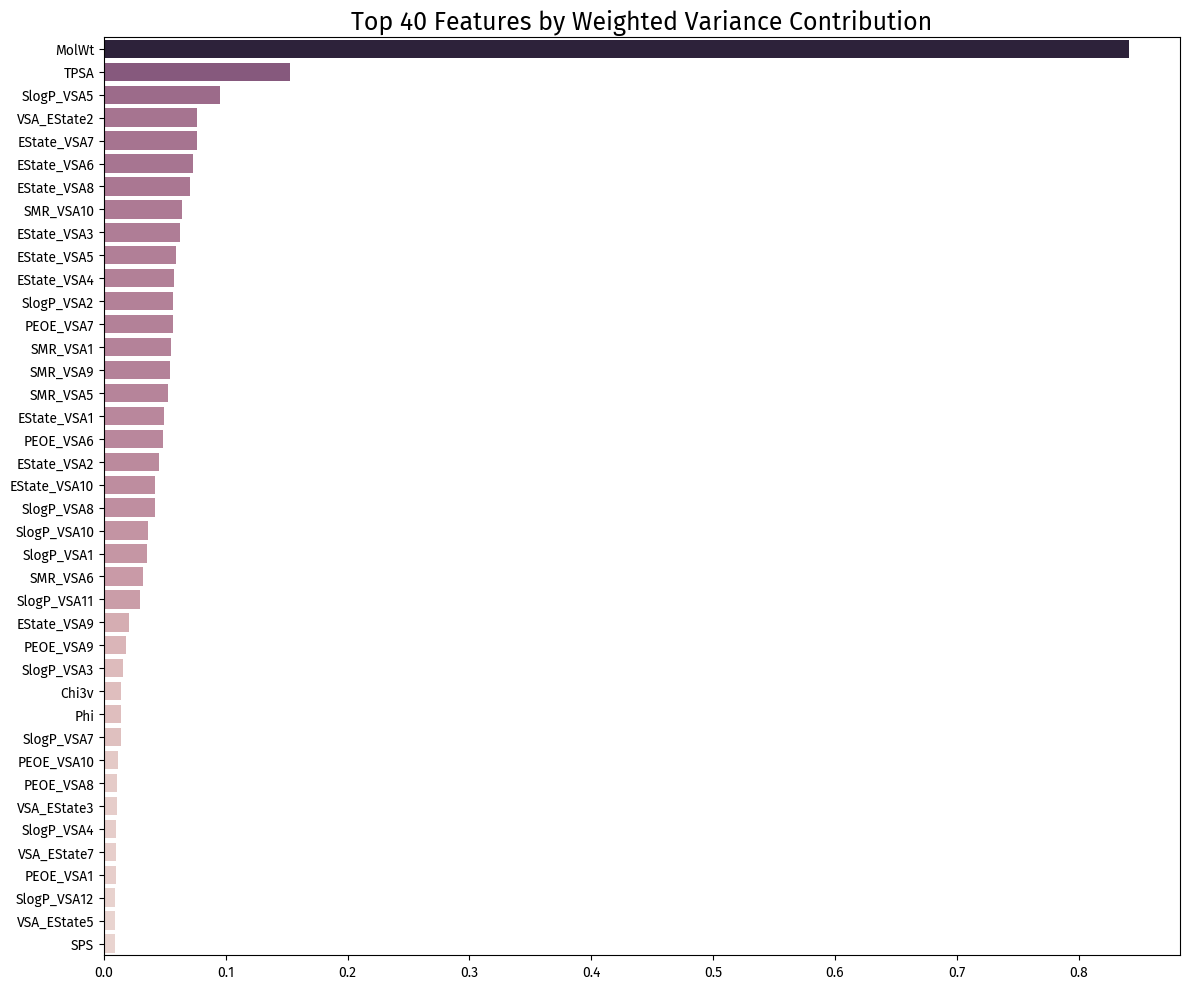

In [16]:
plt.figure(figsize=(12, 10))
sns.barplot(
    x=feature_rank.head(40).values,
    y=feature_rank.head(40).index,
    hue=np.log(feature_rank.head(40).values),
    legend=False,
)
plt.xlabel("", fontsize=14)
plt.ylabel("", fontsize=14)
plt.title("Top 40 Features by Weighted Variance Contribution", fontsize=18)
plt.tight_layout()
plt.show()

In [17]:
tgss_most_important_features.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'reduced_TgSS.csv'))